In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import eviltransform
from datetime import datetime
import time
import glob
import math

# 0. Testing and Plotting Data

In [2]:
data_1201 = pd.read_csv('../../Data_Warehouse/DiDi_XiAn/gps_20161201')

In [3]:
df = data_1201

In [4]:
df.columns = ['driver_ID', 'order_ID', 'time', 'lon', 'lat']

In [5]:
lat_lon = df.groupby(['lat', 'lon']).size()

In [6]:
lat_lon = lat_lon.to_frame().reset_index()

In [7]:
lat_lon = lat_lon.drop(columns=[0])

In [12]:
lat_lon_wgs = lat_lon.apply(lambda x: eviltransform.gcj2wgs(x.lat, x.lon), axis = 1)

In [13]:
lat_lon_wgs = pd.DataFrame(list(lat_lon_wgs))

In [14]:
lat_lon_wgs.columns = ['lat_wgs', 'lon_wgs']

In [15]:
lat_lon[['lat_wgs', 'lon_wgs']] = lat_lon_wgs

In [18]:
sample = df.head(1000000)

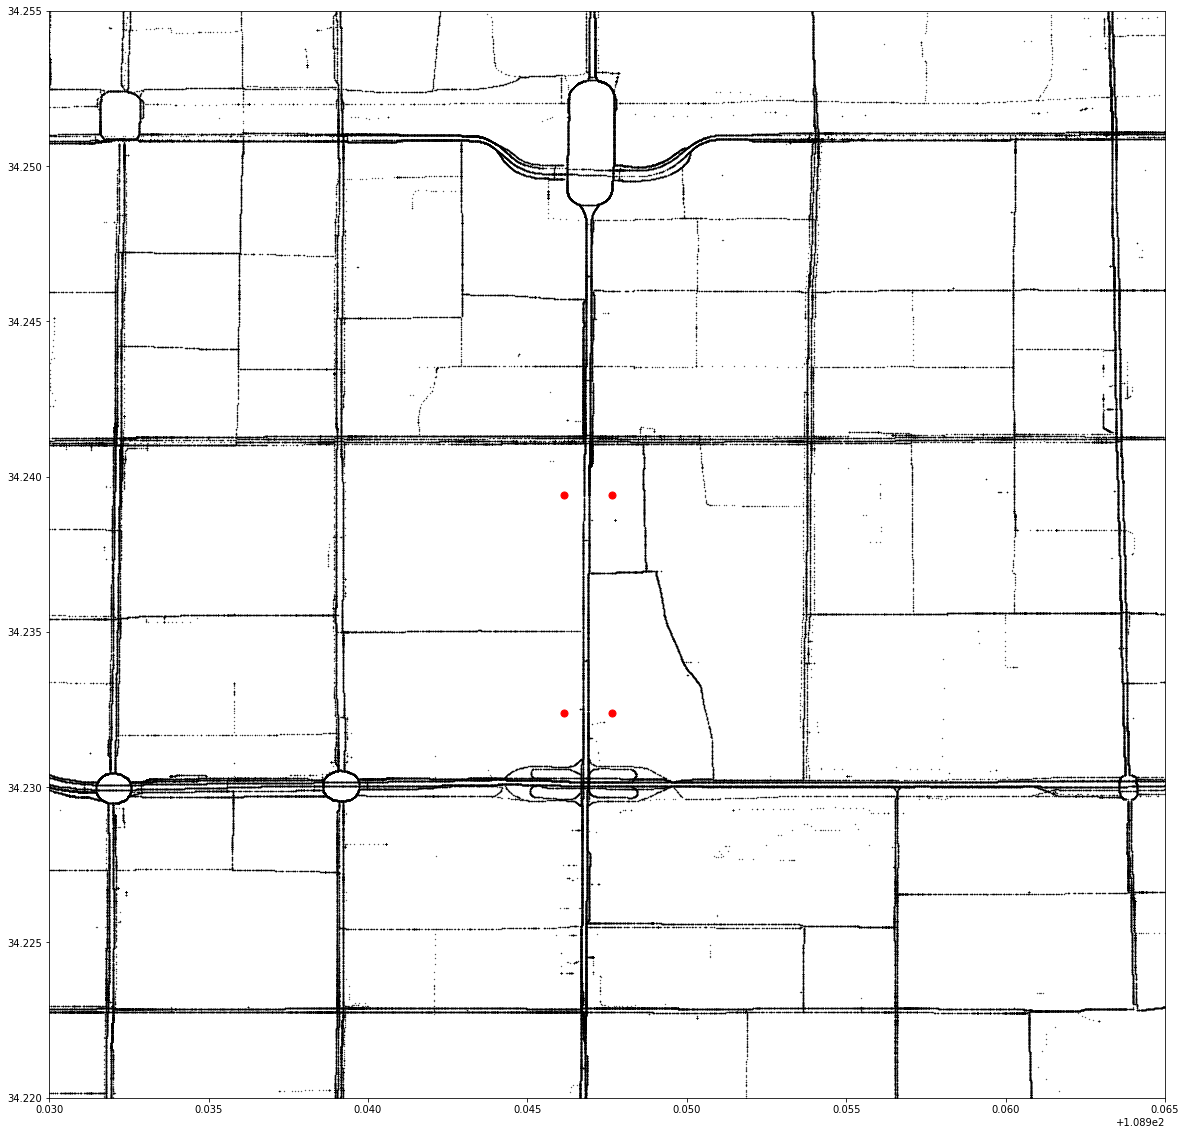

In [19]:
plt.figure(figsize=(20,20))

plt.xlim(108.93, 108.965)
plt.ylim(34.22, 34.255)
plt.scatter(sample.lon, sample.lat, s = 0.1, c = 'black')

# plt.scatter(sample.lon, sample.lat, s = 0.1, c = 'b', label = 'dir_SN = S')
# plt.scatter(sample.lon, sample.lat, s = 0.1, c = 'r', label = 'dir_SN = N')
# plt.scatter(sample.lon, sample.lat, s = 0.1, c = 'g', label = 'dir_WE = W')
# plt.scatter(sample.lon, sample.lat, s = 0.1, c = 'y', label = 'dir_WE = E')
# plt.scatter(sn_sample_s.lon, sn_sample_s.lat, s = 0.1, c = 'b')
# plt.scatter(sn_sample_n.lon, sn_sample_n.lat, s = 0.1, c = 'r')
# plt.scatter(sn_sample_o.lon, sn_sample_o.lat, s = 0.1, c = 'c')

plt.scatter(108.947656, 34.239406, c = 'r', s = 50)
plt.scatter(108.946151, 34.239406, c = 'r', s = 50)
plt.scatter(108.946151, 34.232401, c = 'r', s = 50)
plt.scatter(108.947656, 34.232401, c = 'r', s = 50)

# plt.savefig('sample_1000000.png', dpi = 300)

plt.show()


# 1. Collecting all distinct points wiht direction information

# 1.1 set bounding area and collect points

In [2]:
bound_ws = eviltransform.wgs2gcj(34.224, 108.929) # west south bound
lat_min = bound_ws[0]
lon_min = bound_ws[1]
bound_en = eviltransform.wgs2gcj(34.253, 108.958) # east north bound
lat_max = bound_en[0]
lon_max = bound_en[1]

In [ ]:
path ='D:/xian'
filenames = glob.glob(path + '//*')

lat_lon_total = pd.DataFrame()

i = 0

for f in filenames:
    i += 1
    start_time = time.time()
    data = pd.read_csv(f, header = None)
    data.columns = ['driver_ID', 'order_ID', 'time', 'lon', 'lat']
    data = data.sort_values(by=['driver_ID', 'order_ID', 'time'])
    
    data = data[ (data.lon >= lon_min) & (data.lon <= lon_max) & (data.lat >= lat_min) & (data.lat <= lat_max)]
    
    data[['pre_DID', 'pre_OID', 'pre_time', 'pre_lon', 'pre_lat']] = data[['driver_ID', 'order_ID', 'time', 'lon', 'lat']].shift(1)
    data = data[~ ((data.driver_ID == data.pre_DID) & (data.order_ID == data.pre_OID) & (data.lon == data.pre_lon) & (data.lat == data.pre_lat))]
    data = data[ data.order_ID == data.pre_OID] # drop rows in which order_id and pre_order_id are not identical
    data = data.drop(columns=['pre_DID', 'pre_OID'])
    data['pre_time'] = data['pre_time'].astype(int)

    data['delta_lon'] = data.lon - data.pre_lon
    data['delta_lat'] = data.lat - data.pre_lat
    data['delta_lat/lon'] = data['delta_lat'] / data['delta_lon']
    data['dir'] = 6
    data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] > 0), 'dir'] = 0 # north
    data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] < 0), 'dir'] = 2 # south
    data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] > 0), 'dir'] = 1 # east
    data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] < 0), 'dir'] = 3 # west
    
    lat_lon = data[['lat', 'lon', 'dir']]
    lat_lon = lat_lon.drop_duplicates()
    
    if lat_lon_total.empty:
        lat_lon_total = lat_lon
    else:
        lat_lon_total = pd.concat([lat_lon_total, lat_lon]).drop_duplicates().reset_index(drop=True)
        
    print('Read file:', f, "--- %s seconds ---" % (time.time() - start_time), ' Shape:', lat_lon_total.shape )
    

In [14]:
lat_lon_total.to_csv('didi_xian_lat_lon_dir_studyarea.csv')

## 1.2 Convert coordinate from gcj to wgs-84

In [15]:
start_time = time.time()
lat_lon_wgs = lat_lon_total.apply(lambda x: eviltransform.gcj2wgs(x.lat, x.lon), axis = 1)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.430131435394287 seconds ---


In [16]:
lat_lon_wgs = pd.DataFrame(list(lat_lon_wgs))

In [18]:
lat_lon_wgs.columns = ['lat_wgs', 'lon_wgs']

In [19]:
lat_lon_total[['lat_wgs', 'lon_wgs']] = lat_lon_wgs

In [21]:
lat_lon_total = lat_lon_total[['lat', 'lon', 'lat_wgs', 'lon_wgs', 'dir']]

In [22]:
lat_lon_total.to_csv('didi_xian_lat_lon_dir_wgs_studyarea.csv')

In [24]:
lat_lon_total.shape

(315935, 5)

# 2 Map all collected points to the OpenStreetMap Links

## 2.1 Export OSM map to PostgreSQL using OSM2pgrouting
```bat   
	osm2pgrouting --f /home/staradmin/Downloads/map.osm --conf /usr/share/osm2pgrouting/mapconfig.xml --dbname routing --username postgres --clean
```

## 2.2 clean OSM network table by removing useless links
* OSM road links contains differet classes and types
    * Classes:
    > - ...
    > - 104: Trunk
    > - 105: Trunk_link
    > - 106: Primary
    > - 107: Primary_link
    > - 108: Secondary
    > - 109: Tertiary
    > - 110: Residential
    > - ...
    * Types:
    > - Oneway
    > - Non-oneway
* Code is written in SQL

``` SQL
    drop table IF EXISTS public.network cascade;

    CREATE TABLE public.network AS SELECT * FROM public.ways;


    delete from public.network
    where class_id = 100  or class_id = 111  
    or class_id = 112 or class_id = 113 or class_id = 114 
    or class_id = 117 or class_id = 118 or class_id = 119 
    or class_id = 122 or class_id = 202

    delete from public.network
    where (gid >= 7139 and gid <= 7143) 
        or (gid >= 2673 and gid <= 2673) 
        or (gid >= 3667 and gid <= 3693) 
        or (gid >= 2275 and gid <= 2275) 
        or (gid >= 3433 and gid <= 3433) 
        or (gid >= 2286 and gid <= 2286) 
        or (gid >= 2449 and gid <= 2454) 
        or (gid >= 2464 and gid <= 2465) 
        or (gid >= 3324 and gid <= 3325) 
        or (gid >= 3764 and gid <= 3769) 
        or (gid >= 2427 and gid <= 2427) 
        or (gid >= 2442 and gid <= 2442) 
        or (gid >= 2202 and gid <= 2202) 
        or (gid >= 2665 and gid <= 2666) 
        or (gid >= 2304 and gid <= 2317) 
        or (gid >= 7326 and gid <= 7331) 
        or (gid >= 7345 and gid <= 7349) 
        or (gid >= 7353 and gid <= 7355) 
        or (gid >= 7278 and gid <= 7323) 
        or (gid >= 1673 and gid <= 1673) 
        or (gid >= 3763 and gid <= 3763) 
        or (gid >= 2445 and gid <= 2445) 
        or (gid >= 2281 and gid <= 2281) 
        or (gid >= 1475 and gid <= 1476) 
        or (gid >= 4902 and gid <= 4902)

    alter table public.network add primary key (gid);
```

## 2.3 Map all points to OSM road links & get link_table

### Mapping Code is written in SQL using PostGIS
```SQL
with points AS (
	select
		gid AS base_id
		, ST_DumpPoints(st_segmentize(st_transform(the_geom, 2163), 10)) as point
		, the_geom as base_geom
		, source as base_source
		, target as base_target
		, one_way
	from public.network
    where ST_Contains(
        ST_MakeEnvelope(108.929, 34.224, 108.956, 34.253, 4326) , the_geom)
)
, lines AS (
	select 
		base_id
		, (point).path[1] AS base_path
		, ST_Transform((point).geom,4326 ) AS curr_point
		, LEAD(ST_Transform((point).geom,4326 )) OVER (PARTITION BY base_id ORDER BY (point).path[1]) As lead_point
		, ST_MakeLine(ST_Transform((point).geom,4326 ), LEAD(ST_Transform((point).geom,4326 )) OVER (PARTITION BY base_id ORDER BY (point).path[1])) AS line
		, one_way
	from points
)
, network_lines_oneway as (
	select 
		base_id
		, base_path
		, curr_point
		, lead_point
		, line
		, one_way
		, ST_Azimuth(curr_point, lead_point ) / pi() * 180 AS az 
	from lines
	where line is not null and one_way = 1
)
, network_lines_twoway as (
	select 
		base_id
		, base_path
		, curr_point
		, lead_point
		, line
		, one_way
		, ST_Azimuth(curr_point, lead_point ) / pi() * 180 AS az 
	from lines
	where line is not null and one_way != 1
)
-- inverse direction on the same line
, network_lines_twoway_inv as (
	select 
		base_id
		, base_path
		, curr_point
		, lead_point
		, line
		, one_way
		, mod( CAST ( ST_Azimuth(curr_point, lead_point ) / pi() * 180 + 180 AS numeric ), 360.0) AS az 
	from lines
	where line is not null and one_way != 1
)
, pairs as (
	select 
		l.base_id
		, l.base_path
		, d.id as point_id
		, d.dir as point_dir
		, d.point
		, d.lon
		, d.lat
		, az 
		, ST_Distance(ST_Transform(l.line, 2163), ST_Transform(d.point, 2163)) as dist_meters
		, ROW_NUMBER() OVER (PARTITION BY id ORDER BY ST_Distance(l.line, d.point) ASC) AS rn
	from network_lines_oneway as l 
    -- network_lines_oneway can be replaced by network_lines_twoway or network_lines_twoway_inv here
    join didi_lat_lon_transfor19_new as d 
		on st_dwithin(l.line, d.point, 0.00016)  
			and  least( abs(az - d.dir * 90),  360 - abs(az - d.dir * 90)) < 45 and d.dir != 6
	order by d.id, dist_meters
)

select base_id as link_id, point_id, point_dir 
from pairs
where rn = 1
order by point_id, base_id, rn

```

## 2.4 Mapping Performance Showing by Figures

1. Study area
    > <img src="./Images/OSM Map.png" width="600" height="400"></img>
2. OpenStreetMap network links at study area
    > <img src="./Images/Whole Network.png" width="600" height="400"></img>
3. Selected links for mapping are colored in red
    > <img src="./Images/Study_Links.png" width="600" height="400"></img>
4. All collected trajectory points as the study area
    > <img src="./Images/All Trajecotry Points.png" width="600" height="400"></img>
5. Mapped points on oneway links
    > <img src="./Images/Mapped Points Oneway.png" width="600" height="400"></img>
6. Mapped points on twoway links
    > <img src="./Images/Mapped Points Twoway.png" width="600" height="400"></img>
7. Mapped points on twoway links in the opposite direction
    > <img src="./Images/Mapped Points Twoway Inverse Direction.png" width="600" height="400"></img>

# 3. Calculate Speed for each link of the traffic network

In [16]:
bound_ws = eviltransform.wgs2gcj(34.224, 108.929) # west south bound
lat_min = bound_ws[0]
lon_min = bound_ws[1]
bound_en = eviltransform.wgs2gcj(34.253, 108.958) # east north bound
lat_max = bound_en[0]
lon_max = bound_en[1]

In [17]:
def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = earth_radius * c
    return d

## 3.1 2016-10 data

In [61]:
path ='D:/xian'
filenames = glob.glob(path + '//*')
filenames.pop() # remove 20161201


speed_data_total = pd.DataFrame()

i = 0

for f in filenames:
    i += 1
    
    start_time = time.time()
    if f != 'D:/xian\\gps_20161201':
        data = pd.read_csv(f, header = None)
    else:
        data = pd.read_csv(f)
    
    data.columns = ['driver_ID', 'order_ID', 'time', 'lon', 'lat']
    data = data[ (data.lon >= lon_min) & (data.lon <= lon_max) & (data.lat >= lat_min) & (data.lat <= lat_max)]
    data = data.sort_values(by=['driver_ID', 'order_ID', 'time'])
    
    # get data in a confined area
    data = data[ (data.lon >= lon_min) & (data.lon <= lon_max) & (data.lat >= lat_min) & (data.lat <= lat_max)]
    
    data[['pre_DID', 'pre_OID', 'pre_time', 'pre_lon', 'pre_lat']] = data[['driver_ID', 'order_ID', 'time', 'lon', 'lat']].shift(1)
    # data = data[~ ((data.driver_ID == data.pre_DID) & (data.order_ID == data.pre_OID) & (data.lon == data.pre_lon) & (data.lat == data.pre_lat))]
    data = data[ data.order_ID == data.pre_OID] # drop rows in which order_id and pre_order_id are not identical
    data = data.drop(columns=['pre_DID', 'pre_OID'])
    data['pre_time'] = data['pre_time'].astype(int)

    data['delta_lon'] = data.lon - data.pre_lon
    data['delta_lat'] = data.lat - data.pre_lat
    data['delta_lat/lon'] = data['delta_lat'] / data['delta_lon']
    data['dir'] = 6
    data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] > 0), 'dir'] = 0 # north
    data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] < 0), 'dir'] = 2 # south
    data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] > 0), 'dir'] = 1 # east
    data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] < 0), 'dir'] = 3 # west
    
    data.lon = data.lon.round(5)
    data.lat = data.lat.round(5)

    # get link_id
    data = data.merge(link_table, how = 'left', left_on = ['lat', 'lon', 'dir'], right_on = ['lat', 'lon', 'dir'])
    
    # clear
    data['link_id_origin'] = data.link_id
    data.link_id = data.groupby('order_ID')['link_id'].fillna(method='ffill')
    data.loc[((data.dir != 6) & (data.link_id_origin.isna())), 'link_id'] = np.nan
    data[['pre_order_ID', 'pre_dir', 'pre_link_id']]= data[['order_ID','dir','link_id']].shift(1)
    data.loc[(data.pre_order_ID == data.order_ID) & (data.dir == 6) & (data.link_id.notnull()) & (data.pre_dir != 6) & (data.pre_link_id.isna()) , 'link_id'] = np.nan
    data = data.drop(columns = ['link_id_origin', 'pre_order_ID',  'pre_dir', 'pre_link_id'])
    
    # remove un-mapped data
    data = data[data.link_id.notnull()]
    data.link_id = data.link_id.astype(int)
    
    # get distance
    data['distance'] = data.apply(lambda x: calculate_distance(x.lat, x.lon, x.pre_lat, x.pre_lon), axis = 1)
    
    # get interval
    data['interval'] = data.time - data.pre_time
    data = data[data.interval <= 15]
    
    # get speed in km/h
    data['speed'] = data.distance / data.interval * 3.6
    
    # get datetime convert from Unix time to GMT+8 time zone
    data['datetime'] = data.apply(lambda x : datetime.utcfromtimestamp(x.time) + timedelta(hours=8), axis = 1)
    
    # get speed data
    speed_data = data[['link_id', 'datetime', 'speed']].groupby(['link_id', pd.Grouper(key = 'datetime', freq = '5Min')]).mean()
    speed_data = speed_data.reset_index()
    speed_data = speed_data.sort_values(by=['datetime', 'link_id'])
    
    if speed_data_total.empty:
        speed_data_total = speed_data
    else:
        speed_data_total = speed_data_total.append(speed_data)
        
    print('Read file:', f, "--- %s seconds ---" % (time.time() - start_time), ' shape :', speed_data_total.shape)
    

Read file: D:/xian\gps_20161001 --- 254.09527802467346 seconds ---  shape : (85650, 3)
Read file: D:/xian\gps_20161002 --- 288.55964636802673 seconds ---  shape : (169375, 3)
Read file: D:/xian\gps_20161003 --- 294.1445953845978 seconds ---  shape : (252282, 3)
Read file: D:/xian\gps_20161004 --- 304.2343349456787 seconds ---  shape : (335734, 3)
Read file: D:/xian\gps_20161005 --- 299.2863268852234 seconds ---  shape : (419613, 3)
Read file: D:/xian\gps_20161006 --- 290.7261197566986 seconds ---  shape : (501447, 3)
Read file: D:/xian\gps_20161007 --- 243.7492482662201 seconds ---  shape : (585208, 3)
Read file: D:/xian\gps_20161008 --- 222.65762066841125 seconds ---  shape : (666430, 3)
Read file: D:/xian\gps_20161009 --- 234.63803434371948 seconds ---  shape : (748554, 3)
Read file: D:/xian\gps_20161010 --- 242.27673268318176 seconds ---  shape : (831277, 3)
Read file: D:/xian\gps_20161011 --- 224.9736840724945 seconds ---  shape : (913360, 3)
Read file: D:/xian\gps_20161012 --- 242

In [63]:
speed_data_total.shape

(2504381, 3)

In [66]:
speed_data_total = speed_data_total[['datetime', 'link_id', 'speed']]

In [68]:
speed_data_total = speed_data_total.sort_values(by=['datetime', 'link_id'])

## 3.2 2016-12-01 data

In [ ]:
start_time = time.time()

data = pd.read_csv('D:/xian\\gps_20161201')

data.columns = ['driver_ID', 'order_ID', 'time', 'lon', 'lat']
data = data[ (data.lon >= lon_min) & (data.lon <= lon_max) & (data.lat >= lat_min) & (data.lat <= lat_max)]
data = data.sort_values(by=['driver_ID', 'order_ID', 'time'])

# get data in a confined area
data = data[ (data.lon >= lon_min) & (data.lon <= lon_max) & (data.lat >= lat_min) & (data.lat <= lat_max)]

data[['pre_DID', 'pre_OID', 'pre_time', 'pre_lon', 'pre_lat']] = data[['driver_ID', 'order_ID', 'time', 'lon', 'lat']].shift(1)
# data = data[~ ((data.driver_ID == data.pre_DID) & (data.order_ID == data.pre_OID) & (data.lon == data.pre_lon) & (data.lat == data.pre_lat))]
data = data[ data.order_ID == data.pre_OID] # drop rows in which order_id and pre_order_id are not identical
data = data.drop(columns=['pre_DID', 'pre_OID'])
data['pre_time'] = data['pre_time'].astype(int)

data['delta_lon'] = data.lon - data.pre_lon
data['delta_lat'] = data.lat - data.pre_lat
data['delta_lat/lon'] = data['delta_lat'] / data['delta_lon']
data['dir'] = 6
data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] > 0), 'dir'] = 0 # north
data.loc[(abs(data['delta_lat/lon']) >= 1) & (data['delta_lat'] < 0), 'dir'] = 2 # south
data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] > 0), 'dir'] = 1 # east
data.loc[(abs(data['delta_lat/lon']) < 1) & (data['delta_lon'] < 0), 'dir'] = 3 # west

data.lon = data.lon.round(5)
data.lat = data.lat.round(5)

# get link_id
data = data.merge(link_table, how = 'left', left_on = ['lat', 'lon', 'dir'], right_on = ['lat', 'lon', 'dir'])

# clear
data['link_id_origin'] = data.link_id
data.link_id = data.groupby('order_ID')['link_id'].fillna(method='ffill')
data.loc[((data.dir != 6) & (data.link_id_origin.isna())), 'link_id'] = np.nan
data[['pre_order_ID', 'pre_dir', 'pre_link_id']]= data[['order_ID','dir','link_id']].shift(1)
data.loc[(data.pre_order_ID == data.order_ID) & (data.dir == 6) & (data.link_id.notnull()) & (data.pre_dir != 6) & (data.pre_link_id.isna()) , 'link_id'] = np.nan
data = data.drop(columns = ['link_id_origin', 'pre_order_ID',  'pre_dir', 'pre_link_id'])

# remove un-mapped data
data = data[data.link_id.notnull()]
data.link_id = data.link_id.astype(int)

# get distance
data['distance'] = data.apply(lambda x: calculate_distance(x.lat, x.lon, x.pre_lat, x.pre_lon), axis = 1)

# get interval
data['interval'] = data.time - data.pre_time
data = data[data.interval <= 15]

# get speed in km/h
data['speed'] = data.distance / data.interval * 3.6

# get datetime convert from Unix time to GMT+8 time zone
data['datetime'] = data.apply(lambda x : datetime.utcfromtimestamp(x.time) + timedelta(hours=8), axis = 1)

# get speed data
speed_data = data[['link_id', 'datetime', 'speed']].groupby(['link_id', pd.Grouper(key = 'datetime', freq = '5Min')]).mean()
speed_data = speed_data.reset_index()
speed_data = speed_data.sort_values(by=['datetime', 'link_id'])

In [72]:
speed_data = speed_data[['datetime', 'link_id', 'speed']]

In [74]:
speed_data = speed_data.sort_values(by=['datetime', 'link_id'])

# 3.3 Check speed values by comparing with the Prediction_north file

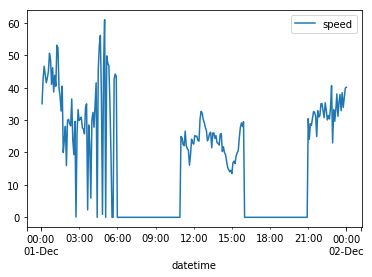

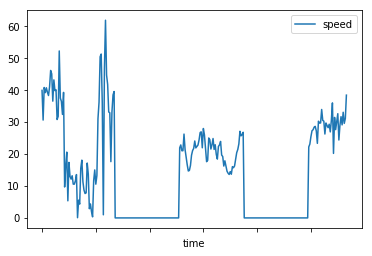

In [491]:
# prediction link north
# OSM link id : 10867, and 20866
speed = speed_data[(speed_data.link_id == 20866) | (speed_data.link_id == 10867)].groupby(['datetime']).speed.mean()
speed = speed.reset_index()
speed = speed.set_index('datetime').resample('5Min').asfreq().fillna(0).reset_index()
speed.plot(x = 'datetime', y = 'speed')
Predictions_north = pd.read_csv('prediction/Predictions_north.csv')
Predictions_north.speed = Predictions_north.speed.replace('x', 0)
Predictions_north.speed = Predictions_north.speed.astype(float)
Predictions_north.plot(x = 'time', y = 'speed')

<Figure size 432x288 with 0 Axes>

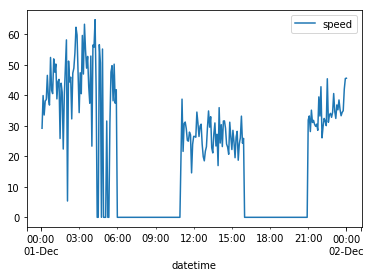

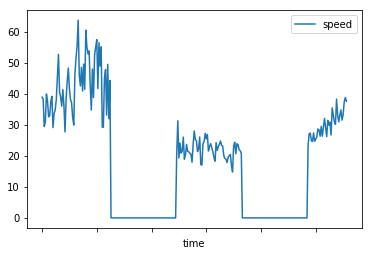

In [490]:
# prediction link south 
# OSM link id : 46, 10047, and 20045
plt.figure(); 
speed = speed_data[(speed_data.link_id == 20045) |(speed_data.link_id == 10047) | (speed_data.link_id == 46)].groupby(['datetime']).speed.mean()
speed = speed.reset_index()
speed = speed.set_index('datetime').resample('5Min').asfreq().fillna(0).reset_index()
ax = speed.plot(x = 'datetime', y = 'speed')
Predictions_south = pd.read_csv('prediction/Predictions_south.csv')
Predictions_south.speed = Predictions_south.speed.replace('x', 0)
Predictions_south.speed = Predictions_south.speed.astype(float)
Predictions_south.plot(x = 'time', y = 'speed')